The logistic regression classifier is a widely used machine learning model that predicts the group or category that an observation belongs to. When implementing this model, most people rely on some library or API: just hand over a dataset and out come the predictions. However, I'm not a fan of using black boxes without first understanding what's going on inside. In fact, lifting the hood on this classifier provides a segue to more complex models such as neural networks. Therefore, in this post, I'd like to explore the methodology behind logistic regression classifiers and walk through how to construct one from scratch.
<!-- TEASER_END -->

**Specifically, a logistic regression classifier determines the *probability* that an observation belongs to one class over another.** If this probability exceeds some threshold, the observation is assigned to a particular class, or else assigned to the other class. For example, such a classifier can decide whether an email is spam or not, or whether a customer will buy a product. Rather than explicitly programming an intricate rule that dictates how the classification should take place, we allow the classifier to *learn* from a labeled dataset and figure out the rule for itself&mdash;a hallmark of machine learning. Since this **training set** informs the classifier of what right and wrong answers look like, this is an example of **supervised learning**.

# Table of contents
1. [Inspecting the data](#cell1)
2. [Developing a hypothesis using the logistic function](#cell2)
3. [Measuring prediction error using the cost function](#cell3)
4. [Minimizing the cost function with batch gradient descent](#cell4)
5. [Training the classifier and making predictions](#cell5)
6. [Assessing and improving performance](#cell6)

<a id="cell1"></a>
# 1. Inspecting the data

Before diving in, let's take a look at the training set we'll be working with and understand what we're trying to predict.

In [1]:
df = pd.read_csv('data/election.csv', header=0)
df.head()

,funds,rating,result
0,0.236,0.302,won
1,0.260,0.270,won
2,0.162,0.305,won
3,0.376,0.337,won
4,0.308,0.362,won


The training set is comprised of hypothetical mayoral election results from a certain country. Here's a description of each column:

- `funds` - campaign money (in millions) raised by the candidate
- `rating` - the candidate's average rating (ranging from 0 to 1) as provided by public opinion polls
- `result` - whether the candidate won or lost the election

`funds` and `rating` are the **features**, while `result` is the **target variable** that defines the classes: winners and losers. Using this training set and a logistic regression classifier, **we aim to predict if a future candidate will win an election.**

Because we'll need to eventually perform computations on the target variable, let's encode its values with numbers ("won" = 1 and "lost" = 0) and convert its contents from string to integer type. 

In [2]:
df.loc[df['result'] == 'won', 'result'] = 1
df.loc[df['result'] == 'lost', 'result'] = 0
df['result'] = df['result'].apply(pd.to_numeric)
df.head()

,funds,rating,result
0,0.236,0.302,1
1,0.260,0.270,1
2,0.162,0.305,1
3,0.376,0.337,1
4,0.308,0.362,1


## Visualizing the data

Let's dive deeper into the training set and see what it looks like.

In [3]:
df.describe()

,funds,rating,result
count,264.000000,264.000000,264.000000
mean,1.080432,0.452564,0.484848
std,0.505437,0.213956,0.500720
min,0.088000,0.059000,0.000000
25%,0.679000,0.273750,0.000000
50%,1.081000,0.456000,0.000000
75%,1.514500,0.604500,1.000000
max,2.000000,0.935000,1.000000


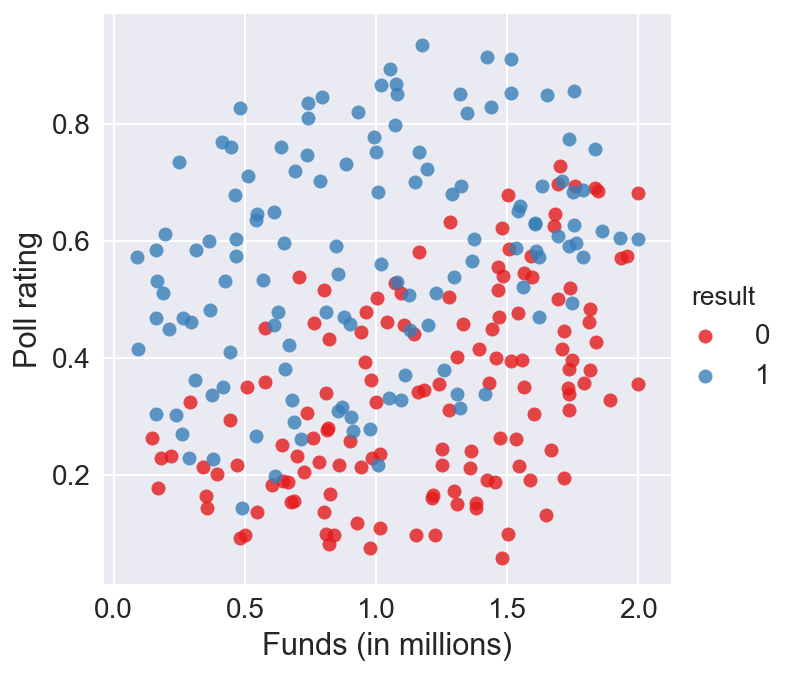

In [4]:
sns.lmplot(
    data=df,
    x='funds',
    y='rating',
    hue='result',
    fit_reg=False,
    palette='Set1'
).set_axis_labels('Funds (in millions)', 'Poll rating');

It seems we have data for 264 candidates, or **training examples**. A quick glance at the training set tells us the two classes are generally found above and below some straight line. In order to make predictions, the classifier will need to identify this **decision boundary**. However, before prognosticating anything, we first need the classifier to somehow compute win probabilities given `funds` and `rating`. 

<a id="cell2"></a>
# 2. Developing a hypothesis using the logistic function

Machine learning models are based on some mathematical function that processes the features $x$ and outputs a value; this function is called the **hypothesis** $h(x)$. Since our classifier of interest outputs probabilities, we need its hypothesis to range between zero and one. We can't use linear functions because probabilities below zero or above one don't make any sense. Therefore, let's turn to the **logistic function**

$$\sigma(z) = \frac{1}{1+\mathrm{e}^{-z}}$$

and see what this function looks like.

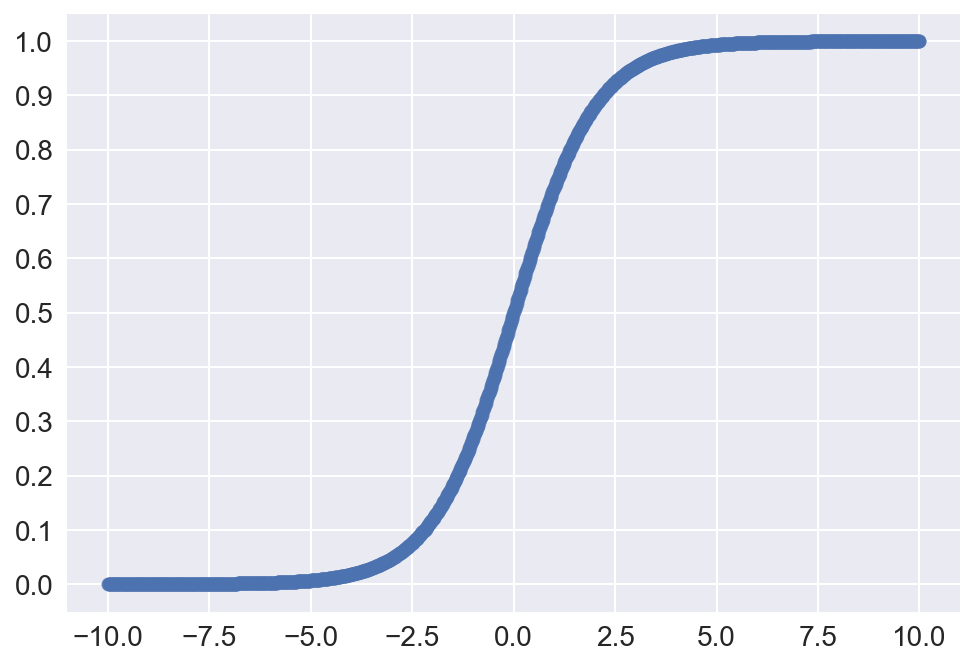

In [5]:
x_values = np.linspace(-10, 10, 1000)
lf_values = special.expit(x_values)

sns.regplot(
    x=x_values,
    y=lf_values,
    fit_reg=False
).set(yticks=np.linspace(0, 1, 11));

We notice that $\lim_{z\rightarrow\infty}\sigma(z) = 1$ and $\lim_{z\rightarrow-\infty}\sigma(z) = 0$, which is perfect since we're working with probabilities. The question is: how do we incorporate `funds` and `rating` into the logistic function to develop a hypothesis? Because we're interested in finding a linear decision boundary, perhaps a [linear combination](https://en.wikipedia.org/wiki/Linear_combination) of the features will suffice:

$$z = \theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2}$$

- $x_1$ and $x_2$ are the features `funds` and `rating`, respectively
- $x_0 = 1$
- $\theta_0$, $\theta_1$ and $\theta_2$ are real numbers

If we input the above expression into the logistic function, we have a potential hypothesis for the classifier:

$$h_\theta(x) = \sigma(\theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2}) = \frac{1}{1+\mathrm{e}^{-(\theta_0{x_0} + \theta_1{x_1} + \theta_2{x_2})}}$$

Specifically, **this hypothesis computes the probability that a candidate will win an election given a set of features.** But how do we know if this is a suitable hypothesis? Well, we can begin by settling on a probability threshold for deciding whether a candidate will win or lose the election. An intuitive threshold for this decision is: predict a candidate will win if the win probability equals or exceeds 50% (i.e., $h_\theta(x)\ge0.5$), otherwise he/she is predicted to lose. If $h_\theta(x) = 0.5$, then $z = 0$; substituting this latter value into the linear combination above and then rearranging yields an intriguing equation: 

$$x_2=-\frac{\theta_0}{\theta_2}-{\frac{\theta_1}{\theta_2}}x_1$$

Notice that this is an equation of a line; in fact, it's the equation of a line that exists on the scatterplot from earlier. However, because this line is linked to the threshold for making predictions, logically, this must be the decision boundary of the classifier! It looks like our choice for the hypothesis wasn't arbitrary after all. Now all that remains is to figure out what are the **parameters** ($\theta_0$, $\theta_1$ and $\theta_2$) of the hypothesis in order to identify the exact decision boundary.

<a id="cell3"></a>
# 3. Measuring prediction error using the cost function

To determine the parameters of our newly formulated hypothesis, let's work backwards and start with how we'd want the logistic regression classifier to perform on the training examples. Hopefully, the *actual winners* have win probabilities near one, while the *actual losers* near zero. Let's go ahead and define the win probability of an actual winner, which is equivalent to the probability of *correctly* classifying an actual winner:

$$P(y = 1 \mid x_{winner}) = h_\theta(x_{winner})$$

where $y$ is the target variable. Since we're performing binary classification, the probability of correctly classifying an actual loser is given by

$$P(y = 0 \mid x_{loser}) = 1-h_\theta(x_{loser})$$

Assuming each training example was independently generated, the probability of correctly classifying *every* actual winner in the training set is the product of their individual probabilities: $\prod_{winners}h_\theta(x)$. Conversely, the probability of correctly classifying *every* actual loser is $\prod_{losers}(1-h_\theta(x))$. Taken together, the joint product represents the probability of correctly classifying *all of the training examples*: 

$$\displaystyle\prod_{y=1}h_\theta(x)\displaystyle\prod_{y=0}(1-h_\theta(x))$$

This joint product can be combined and written more succinctly, and is called the **likelihood** of the data for a set of parameters $\theta$:

$$\mathcal{L}(\theta) = \displaystyle\prod_{i=1}^{m}h_\theta({x}^{(i)})^{y^{(i)}}(1-h_\theta({x}^{(i)}))^{1-y^{(i)}}$$

where $({x}^{(i)}, {y}^{(i)})$ refers to the $i$th training example and  $m$ is the number of training examples. Since we'd like to maximize the probability of correctly classifying the entire training set, we need to maximize $\mathcal{L}(\theta)$. It turns out that it's much easier to maximize its logarithm:

$$\log{\mathcal{L}(\theta)} =\sum_{i=1}^{m}{y}^{(i)}\log{h_\theta(x^{(i)})} + (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))$$

The above expression took two things into account: a) $\log(xy) = \log(x) + \log(y)$ and b) logarithmic functions are [monotonically increasing](https://opencurriculum.org/5512/monotonically-increasing-and-decreasing-functions-an-algebraic-approach/). Maximizing $\log{\mathcal{L}(\theta)}$ is also equivalent to *minimizing* its negative:

$$-\log{\mathcal{L}(\theta)} = \sum_{i=1}^{m}{-y}^{(i)}\log h_\theta(x^{(i)}) - (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))$$

This expression represents the probability of *incorrectly* classifying the training set, or in other words, the total error or cost of the predictions made by the classifier. The mean cost of a prediction can then serve as a convenient metric for how well the classifier performs, and is called the **cost function**:

$$C(\theta) = \frac{1}{m}\sum_{i=1}^{m}{-y}^{(i)}\log h_\theta(x^{(i)}) - (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))$$

**Therefore, our goal is to the identify the parameters $\theta$ that minimize the cost function.** Programming the cost function would typically require nested `for` loops and/or the use of `sum()`. A more elegant and computationally efficient method takes advantageous of linear algebra to arrive at a vectorized form:

$$C(\vec{\theta}) = \frac{1}{m}\Big({-\mathbf{y}}^{\rm T}\log \sigma({X}{\vec\theta}) - (1 - \mathbf{y})^{\rm T}\log(1 - \sigma({X}{\vec\theta}))\Big)$$
$$\\$$
$$\vec{\theta}=
\left[\begin{array}{cccc}
\theta_0 \\
\theta_1 \\
\theta_2 
\end{array}\right]\quad{X}=
\left[\begin{array}{cccc}
x_0 & x_1^{(1)} & x_2^{(1)} \\
x_0 & x_1^{(2)} & x_2^{(2)} \\
\vdots & \vdots & \vdots \\
x_0 & x_1^{(m)} & x_2^{(m)}
\end{array}\right]\quad\mathbf{y}=
\left[\begin{array}{cccc}
y^{(1)} \\
y^{(2)} \\
\vdots \\
y^{(m)}
\end{array}\right]$$
$\\$

In [6]:
def cost_function(X, y, theta):    
    m = len(X) 
    hypothesis = special.expit(X.values @ theta)
    return (
        (-(y.values.T) @ np.log(hypothesis)) -
        ((1 - y.values).T @ np.log(1 - hypothesis))
    ) / m

## Setting up the features and target variable

We'll utilize the vectorized version of the cost function so while we're here, let's place the features into a **design matrix** $X$.

In [7]:
m = len(df)
X = pd.concat(
    (pd.Series(np.ones(m), name='x0'), df[['funds', 'rating']]),
    axis=1
)

X.head()

,x0,funds,rating
0,1.0,0.236,0.302
1,1.0,0.260,0.270
2,1.0,0.162,0.305
3,1.0,0.376,0.337
4,1.0,0.308,0.362


Let's also set up the target variable in a vector $\mathbf{y}$.

In [8]:
y = df.loc[:, 'result'].to_frame()
y.head()

,result
0,1
1,1
2,1
3,1
4,1


<a id="cell4"></a>
# 4. Minimizing the cost function with batch gradient descent 

Because the cost function $C(\theta)$ of a logistic regression classifier is [convex](http://mathgotchas.blogspot.com/2011/10/why-is-error-function-minimized-in.html), $C(\theta)$ is guaranteed to have a global minimum&mdash;we just need to find the corresponding parameters $\theta$. Unfortunately, there's no known [closed-form solution](https://www.quora.com/Does-there-exist-an-analytical-solution-to-Logistic-Regression-similar-to-that-of-the-Normal-Equation-for-Linear-Regression) that conveniently provides us these values&mdash;the classifier will need to *learn* them from the training set.

One learning algorithm is **batch gradient descent**:

1. Select arbitrary values for the parameters $\theta$
2. Compute the steepness, or gradient of $C(\theta)$ at the current values of the parameters
3. Subtract the gradient from all values of the parameters *simultaneously*
4. Repeat steps 2 and 3 of updating the parameters until the gradient approaches zero, i.e., we've converged to the minimum of $C(\theta)$

**Here's an intuitive perspective of this algorithm:** imagine a hiker that's stranded somewhere on a mountain (step 1) and wants to reach the bottom. Unfortunately, visibility is low due to thick fog&mdash;the way down isn't obvious and the hiker wants to get down as soon as possible. First, the hiker examines the immediate surroundings and identifies the direction of the steepest incline (the gradient in step 2). Next, the hiker moves a set distance, perhaps as far as is visible in the fog, in the *opposite* direction (step 3); thereby, arriving at a slightly lower position on the mountain. The hiker then reassesses the steepness again and repeats this process until he/she eventually arrives at the bottom (step 4).

The gradient of $C(\theta)$ is given by its partial derivatives with respect to the parameters $\theta$:

$$\frac{\partial}{\partial\theta_j}C(\theta) = \frac{1}{m}\sum_{i=1}^{m}{x_j}^{(i)}({h_\theta}(x^{(i)}) - y^{(i)})$$

where $j = 0, 1\dots n$ with $n$ being the number of features. This algorithm is called *batch* gradient descent because we process *all* of the training examples prior to computing the gradient and updating the parameters. The update formula used in the algorithm for each iteration is

$$\theta_j := \theta_j - \alpha\frac{\partial}{\partial\theta_j}C(\theta) = \theta_j - \frac{\alpha}{m}\sum_{i=1}^{m}{x_j}^{(i)}({h_\theta}(x^{(i)}) - y^{(i)})$$

where $\alpha$ dictates the magnitude of the update (or the set distance the hiker decided to move) and is called the **learning rate**. If $\alpha$ is too small, we may take a long time to converge to the minimum of $C(\theta)$. On the other hand, if $\alpha$ is too large, we may overshoot the minimum and the parameters may oscillate or even diverge! Once we've converged to the minimum of $C(\theta)$, the classifier will have learned the parameters of the hypothesis and will be equipped to make predictions.

A vectorized form of the update formula is

$$\vec{\theta} := \vec{\theta} - \frac{\alpha}{m}{X^{\rm T}}({\sigma(X\vec{\theta}) - \mathbf{y}})$$

It's also probably a good idea to keep track of the value of the cost function during each iteration to confirm that we've indeed converged to the minimum.

In [9]:
def gradient_descent(X, y, alpha, iterations):
    m = len(X)
    current_theta = np.zeros((X.shape[1], 1))
    cost_values = np.empty(iterations)
    
    for iteration in range(iterations):
        hypothesis = special.expit(X.values @ current_theta)
        current_theta -= (X.values.T @ (hypothesis - y.values)) * alpha / m
        cost_values[iteration] = cost_function(X, y, current_theta)     
    
    return current_theta, cost_values

<a id="cell5"></a>
# 5. Training the classifier and making predictions

Prior to running the learning algorithm, we need to pick a learning rate and the desired number of iterations.

In [10]:
alpha = 1
iterations = 1500

It's finally time to train the logistic regression classifier and identify the parameters $\theta$!

In [11]:
theta, cost_history = gradient_descent(X, y, alpha, iterations)

for i, parameter in enumerate(theta):
    print('theta{} = {}'.format(i, parameter))

theta0 = [-1.73093143]
theta1 = [-2.36802783]
theta2 = [ 9.47343264]


Using batch gradient descent, the classifier has learned the parameters $\theta$ that minimize the cost function, has a functional hypothesis, and is ready to make predictions. However, let's first verify we've truly minimized the cost function by visualizing its value at each iteration.

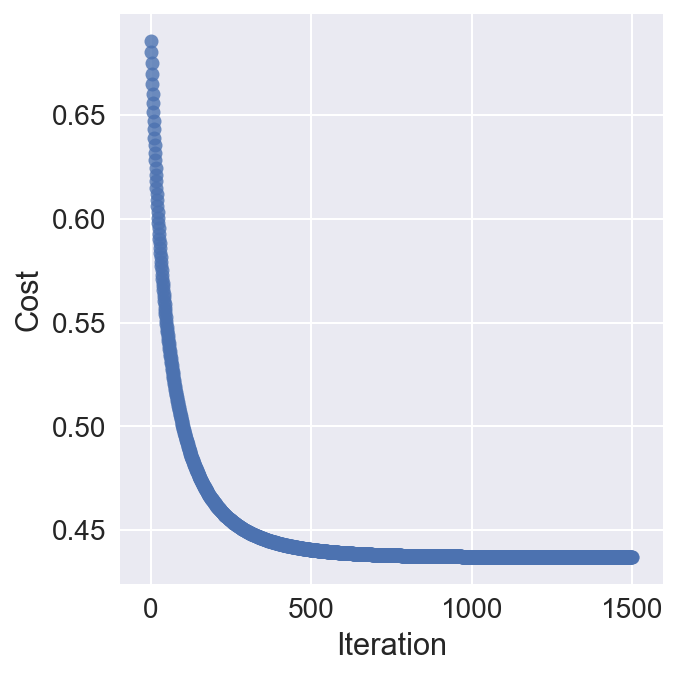

In [12]:
sns.lmplot(
    x='Iteration',
    y='Cost',
    data=pd.DataFrame({'Iteration': range(iterations), 'Cost': cost_history}),
    fit_reg=False
);

Excellent, the cost function converges so we don't need to alter our choices for $\alpha$ and `iterations`. Let's also use the learned parameters to visualize the decision boundary of the classifier using the equation of the line from earlier:

$$x_2=-\frac{\theta_0}{\theta_2}-{\frac{\theta_1}{\theta_2}}x_1$$
$ \\ $

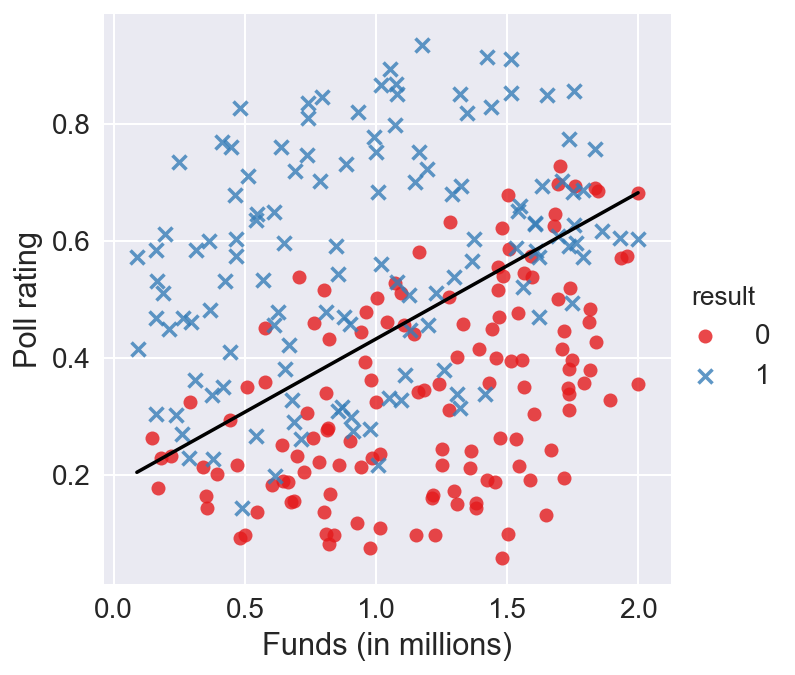

In [14]:
x1_vals = np.linspace(X['funds'].min(), X['funds'].max(), iterations)
x2_vals = (-theta[0, 0] - (theta[1, 0] * x1_vals)) / theta[2, 0]

sns.lmplot(
    data=pd.concat((X, y), axis=1),
    x='funds',
    y='rating',
    hue='result',
    fit_reg=False,
    markers=['o', 'x'],
    palette='Set1'
).set_axis_labels('Funds (in millions)', 'Poll rating');

plt.plot(
    x1_vals,
    x2_vals,
    color='black'
);

## The crystal ball awaits

The classifier looks good to go! Let's have it make a prediction on a **test example** and determine whether a candidate with 1.1 million in campaign funds and a poll rating of 0.52 will win a mayoral election. 

In [15]:
test_example = np.array([1, 1.1, 0.52])
special.expit(test_example @ theta)

array([ 0.64346218])

This candidate has a 64% chance of winning. According to the probability threshold we decided on earlier, the classifier predicts the candidate will win. We can establish the **classification accuracy** by examining how well the classifier performs on the training set. Again, we'll make use of the threshold: if $h_\theta(x) \ge 0.5$, then we predict a win, otherwise a loss.

In [16]:
def predict(X, theta):
    return special.expit(X.values @ theta) >= 0.5

In [17]:
(predict(X, theta) == y.values).sum() / m

0.75

It looks like the classifier has an accuracy of 75%. Let's compare its performance with a logistic regression classifier from Scikit-learn, Python's go-to machine learning library.

In [18]:
from sklearn import linear_model

classifier = linear_model.LogisticRegression(penalty='l2', C=1e10)
classifier.fit(X, y.values.ravel())
classifier.score(X, y)

0.75

Excellent! Our homemade logistic regression classifier is just as accurate as the one from a tried-and-true machine learning library. However, we evaluated the performance of the model on the same dataset used to train it, which gives us an overly optimistic accuracy measurement and isn't representative of the model's performance on unseen data, but that's a story for another blog post.

In addition, the training set in this example is overly simplified. With real-world datasets, we can run into dozens of features and the classes may not be so well-separated. Our classifier would still be functional but wouldn't likely hold a candle to the highly optimized one from Scikit-learn. In addition, with multiple features, a logistic regression classifier would no longer be seeking a decision boundary that's a straight line. Rather, the classifier would learn the parameters that describe a multi-dimensional **hyperplane**, which can be very difficult to visualize.

<a id="cell6"></a>
# 6. Assessing and improving performance

Using classification accuracy alone provides a superficial and at times misleading picture of the classifier's performance. At the very least, a **confusion matrix** would reveal whether the classifier's mistakes are mostly false positives or false negatives. However, there's no reason to stop there; examining other performance metrics, such as precision and recall, would help narrow down whether this is a suitable model for making predictions on our data, or perhaps we should try a different one.

There are also numerous ways to enhance our classifier:

- Instead of choosing a value for `iterations`, we could automatically stop iterating once the difference between successive values of the cost function drops below a specified tolerance
- We could perform feature scaling or normalization to speed up the learning algorithm
- We could find an optimal learning rate
- In this example we performed binary classification, but we could adapt the classifier to learn from a training set comprising [multiple classes](https://en.wikipedia.org/wiki/Multiclass_classification)

In addition, for each iteration in the batch gradient descent algorithm, we waited until we had processed every single training example prior to computing the gradient and updating the parameters. What if instead our dataset had *millions* of training examples? That would be computationally expensive. More suitable options in this scenario would be to use a subset of the training set (**mini-batch gradient descent**), or compute the gradient and update the parameters as each training example is processed (**stochastic gradient descent**). Moreover, gradient descent is one of [many](https://en.wikipedia.org/wiki/Mathematical_optimization#Optimization_algorithms) learning algorithms&mdash;some don't require picking a learning rate, while others converge to the minimum of the cost function much faster.

Finally, instead of choosing a linear combination of the features and a straight line as the decision boundary, we could've combined the features in a higher-order polynomial to achieve a more complex decision boundary; this may have enabled the classifier to perform even better. However, this strategy also increases the chance of building a classifier that *memorizes* the training set but fails to generalize a pattern, and thus performs poorly on test examples&mdash;a cardinal concern in machine learning called **overfitting**. To counter the risk of overfitting, we could incorporate **regularization** into the learning algorithm, but that deserves its very own blog post.

If you made it this far, you should have a good grasp of how to construct a logistic regression classifier from the ground up! I hope you also found this walkthrough useful as a peek under the hood of a popular machine learning model. At the very least, becoming familiar with the thought process, terminology, logic and math behind this classifier can only help in traversing the vast machine learning landscape.

If you'd like to play around with the code, here's the [GitHub repo](https://github.com/redwanhuq/machine-learning). As always, don't hesitate to leave your comments below.